In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import butter, lfilter, spectrogram
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

In [ ]:
directory = "./Desktop/data"
image_directory = os.path.join(directory, "images")
os.makedirs(image_directory, exist_ok=True)

cols = ['Output1', 'Output2', 'Output3', 'Output4', 'x1', 'x2', 'x3', 'x4']

image_mapping = {
    'start zero.png': 0, 'start one.png': 1, 'start two.jpg': 2, 'start three.jpg': 3, 'start four.jpg': 4,
    'start five.jpg': 5, 'start six.jpg': 6, 'start seven.jpg': 7, 'start eight.jpg': 8, 'start nine.jpg': 9,
    'start animal.jpg': -1
}

st_ind = list(image_mapping.keys())
end_ind = ['end zero.png', 'end one.png', 'end two.jpg', 'end three.jpg', 'end four.jpg', 'end five.jpg', 
           'end six.jpg', 'end seven.jpg', 'end eight.jpg', 'end nine.jpg', 'end animal.jpg']

all_files_standardized = []
image_mapping_list = []

In [ ]:
image_counter = 1

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        
        try:
            df = pd.read_csv(file_path, header=None, dtype=str)
        except pd.errors.DtypeWarning:
            df = pd.read_csv(file_path, header=None, low_memory=False)
        
        if len(df.columns) == len(cols):
            df.columns = cols
            df = df.drop(cols[4:], axis=1)
            final_df = []

            for a, b in zip(st_ind, end_ind):
                start_idx = df[df['Output1'] == a].index
                end_idx = df[df['Output1'] == b].index
                temp_df = []

                for i, j in zip(start_idx, end_idx):
                    row = df.iloc[i+1:j].copy()  
                    row['Number'] = image_mapping[a]  
                    temp_df.append(row)

                if temp_df:
                    merged_df = pd.concat(temp_df)
                    final_df.append(merged_df)

            st_final_df = []
            for segment_df in final_df:
                scaler = MinMaxScaler()
                df_to_scale = segment_df.drop(columns=['Number'])
                standard_df = scaler.fit_transform(df_to_scale)
                standard_df = pd.DataFrame(standard_df, columns=cols[:4])
                standard_df['Number'] = segment_df['Number'].values 
                st_final_df.append(standard_df)

            if st_final_df:
                combined_standard_df = pd.concat(st_final_df)
                all_files_standardized.append(combined_standard_df)

                # Generate and save spectrogram for each segment
                for idx, segment in enumerate(st_final_df):
                    f, t, Sxx = spectrogram(segment['Output1'].astype(float).values, fs=1.0, nperseg=min(256, len(segment)))
                    plt.figure(figsize=(6, 4))
                    plt.pcolormesh(t, f, 10 * np.log10(Sxx))
                    plt.axis('off')
                    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
                    plt.margins(0, 0)
                    plt.gca().xaxis.set_major_locator(plt.NullLocator())
                    plt.gca().yaxis.set_major_locator(plt.NullLocator())
                    new_image_name = f"{image_counter}.png"
                    image_path = os.path.join(image_directory, new_image_name)
                    plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
                    plt.close()

                    image_mapping_list.append({"ImageFile": new_image_name, "Number": segment['Number'].values[0]})
                    image_counter += 1
final_combined_df = pd.concat(all_files_standardized)

In [22]:
scaler = MinMaxScaler()
my_df_to_scale = final_combined_df.drop(columns=['Number'])
my_df_scaled = scaler.fit_transform(my_df_to_scale)
my_df = pd.DataFrame(my_df_scaled, columns=cols[:4])
my_df['Number'] = final_combined_df['Number'].values

output_file_path = os.path.join(directory, "my_df.csv")
my_df.to_csv(output_file_path, index=False)

image_mapping_df = pd.DataFrame(image_mapping_list)
image_mapping_file_path = os.path.join(directory, "image_mapping.csv")
image_mapping_df.to_csv(image_mapping_file_path, index=False)

print(f"Combined and normalized data has been saved to {output_file_path}")
print(f"Spectrogram images have been saved to {image_directory}")
print(f"Image mapping has been saved to {image_mapping_file_path}")

Combined and normalized data has been saved to ./Desktop/data\my_df.csv
Spectrogram images have been saved to ./Desktop/data\images
Image mapping has been saved to ./Desktop/data\image_mapping.csv


In [19]:
df = pd.read_csv("./Desktop/data/my_df.csv")
print(df.shape)
df.head()

(266272, 5)


,Output1,Output2,Output3,Output4,Number
0,0.962573,0.292035,0.070330,0.977642,0
1,0.949123,0.402655,0.041319,0.981030,0
2,0.964912,0.207965,0.000000,0.949864,0
3,1.000000,0.000000,0.055824,0.966802,0
4,0.986842,0.036873,0.067692,0.948509,0


In [20]:
value_counts = df['Number'].value_counts()
print(value_counts)
num_unique_values = df['Number'].nunique()
print(f'The number of unique values: {num_unique_values}')

Number
 6    26666
 3    25920
 5    25096
-1    25040
 7    23912
 0    23893
 4    23456
 2    23338
 1    23287
 8    22863
 9    22801
Name: count, dtype: int64
The number of unique values: 11


In [21]:
directory = "./Desktop/data"
image_directory = os.path.join(directory, "images")
image_mapping_file_path = os.path.join(directory, "image_mapping.csv")
image_mapping_df = pd.read_csv(image_mapping_file_path)

In [22]:
imgx = cv2.imread("./Desktop/data/images/1.png")
imgx.shape

(400, 600, 3)

In [23]:
directory = "./Desktop/data"
image_directory = os.path.join(directory, "images")
image_mapping_file_path = os.path.join(directory, "image_mapping.csv")

image_mapping_df = pd.read_csv(image_mapping_file_path)

img_height, img_width, img_channels = 400, 600, 3

In [24]:
def load_images(image_directory, image_mapping_df):
    images = []
    labels = []
    for _, row in image_mapping_df.iterrows():
        img_path = os.path.join(image_directory, row['ImageFile'])
        image = load_img(img_path, target_size=(img_height, img_width))
        image = img_to_array(image)
        images.append(image)
        labels.append(row['Number'])
    return np.array(images), np.array(labels)

images, labels = load_images(image_directory, image_mapping_df)

images = images / 255.0

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [25]:
images.shape

(209, 400, 600, 3)

In [26]:
labels.shape

(209,)

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = Sequential()
model.add(Input(shape=(img_height, img_width, img_channels)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(len(np.unique(labels)), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

print(model.summary())


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 398, 598, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 398, 598, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 199, 299, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 197, 297, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 197, 297, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 98, 148, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 96, 146, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 96, 146, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 48, 73, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,075 (437.79 KB)

 Trainable params: 111,627 (436.04 KB)

 Non-trainable params: 448 (1.75 KB)

None


In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(images_train, labels_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 8s/step - accuracy: 0.1250 - loss: 2.4989 - val_accuracy: 0.0294 - val_loss: 2.4008
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step - accuracy: 0.1336 - loss: 2.3701 - val_accuracy: 0.0294 - val_loss: 2.4006
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.1845 - loss: 2.3674 - val_accuracy: 0.0294 - val_loss: 2.3975
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - accuracy: 0.2012 - loss: 2.2764 - val_accuracy: 0.0294 - val_loss: 2.4014
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - accuracy: 0.1550 - loss: 2.2962 - val_accuracy: 0.0294 - val_loss: 2.4050
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - accuracy: 0.1679 - loss: 2.3005 - val_accuracy: 0.0294 - val_loss: 2.4095
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - accuracy: 0.1682 - loss: 2.2774 - val_accuracy: 0.0294 - val_loss: 2.4127
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - accuracy: 0.1252 - loss: 2.3661 - val_accuracy: 0.0294 - val_loss: 2.4176


In [34]:
test_loss, test_accuracy = model.evaluate(images_test, labels_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.0685 - loss: 2.3990
Test loss: 2.3991587162017822
Test accuracy: 0.0714285746216774


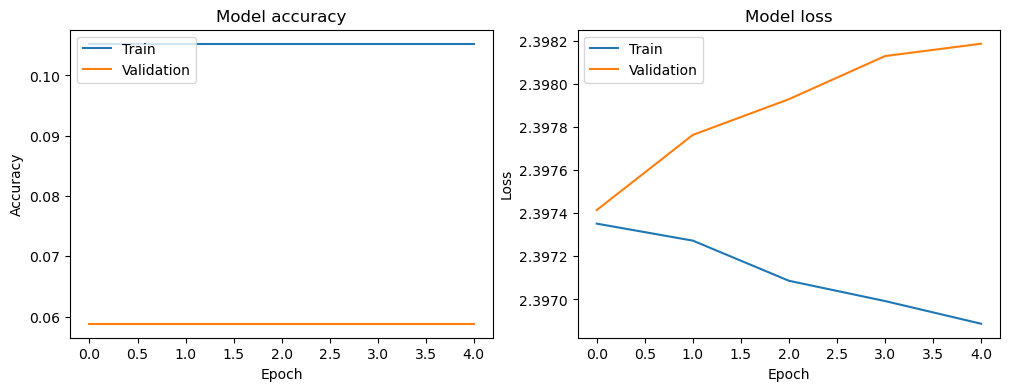

In [35]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')  
    plt.show()
plot_training_history(history)

Test accuracy: 0.023809523809523808
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         4
          10       0.50      0.20      0.29         5

    accuracy                           0.02        42
   macro avg       0.05      0.02      0.03        42
weighted avg       0.06      0.02      0.03        42



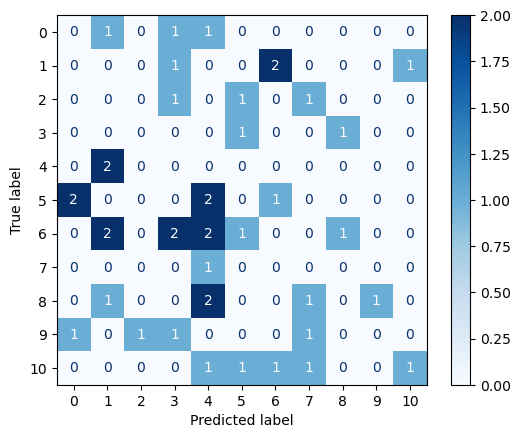

In [46]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Flatten the images for SVM
n_samples = images.shape[0]
flat_images = images.reshape(n_samples, -1)

# Split the data into training and testing sets
flat_images_train, flat_images_test, labels_train, labels_test = train_test_split(flat_images, labels, test_size=0.2, random_state=42)

# Create the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Train the model
svm_model.fit(flat_images_train, labels_train)

# Evaluate the model
labels_pred = svm_model.predict(flat_images_test)
test_accuracy = accuracy_score(labels_test, labels_pred)
print(f"Test accuracy: {test_accuracy}")

# Print classification report
print(classification_report(labels_test, labels_pred))

# If you want to plot the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(labels_test, labels_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels))
disp.plot(cmap=plt.cm.Blues)
plt.show()


Skipping empty file: image_mapping.csv


C:\Users\hp\AppData\Local\Temp\ipykernel_9268\2678904022.py:95: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array([apply_fft(segment) for segment in st_final_df])


Class Distribution:
 6    26666
 3    25920
 5    25096
-1    25040
 7    23912
 0    23893
 4    23456
 2    23338
 1    23287
 8    22863
 9    22801
Name: count, dtype: int64
Adjusted test size: 0.2


ValueError: Found input variables with inconsistent numbers of samples: [11, 266272]